<a href="https://colab.research.google.com/github/ManikandanM13/BOA-DENSENET/blob/main/augmented_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
import math
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, models
import sklearn.metrics
from sklearn.svm import SVC

In [ ]:
#Load the dataset
file_path = '/content/drive/MyDrive/ColonTumor (1).csv'
df = pd.read_csv(file_path)
#Display the first few rows to understand the structure
print(df.head())

    Patients  Gene 1  Gene 2  Gene 3  Gene 4  Gene 5  Gene 6  Gene 7  Gene 8  \
0  Patient 1  8590.0  5470.0  4260.0  4060.0  2000.0  5280.0  2170.0  2770.0   
1  Patient 2  9160.0  6720.0  4880.0  3720.0  2020.0  5570.0  3850.0  2790.0   
2  Patient 3  3830.0  6970.0  5370.0  4710.0  1170.0  1570.0  1330.0  1470.0   
3  Patient 4  6250.0  7820.0  5960.0  3980.0  2000.0  2130.0  1530.0  1710.0   
4  Patient 5  3230.0  3690.0  3400.0  3460.0  2180.0  2920.0  2070.0  2950.0   

   Gene 9  ...  Gene 1992  Gene 1993  Gene 1994  Gene 1995  Gene 1996  \
0  7530.0  ...       67.6     260.00      139.0       88.2       39.7   
1  7020.0  ...       92.2      96.30      151.0       82.2       85.0   
2  3300.0  ...       82.7      31.10      194.0       77.0      225.0   
3  3870.0  ...       41.7       5.93      183.0       74.5       67.7   
4  3300.0  ...       76.6     161.00       61.7       54.6      223.0   

   Gene 1997  Gene 1998  Gene 1999  Gene 2000    result  
0       67.8       75.

In [ ]:
#Handle missing values, drop row if missing..
df = df.dropna()

In [ ]:
# Handle categorical variables
label_encoder = LabelEncoder()
df['result'] = label_encoder.fit_transform(df['result'])

In [ ]:
# Split the dataset into features and labels
X = df.drop('result', axis=1)
y = df['result']  # Labelsprint(df.info())# Assuming 'Patients' is the column with patient identifiers
X = X.drop('Patients', axis=1)#  Min-Max Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**BOA**

In [ ]:
def butterfly_optimization(X_train, y_train, n_iterations):
    n_features = X_train.shape[1]
    n_population = 1936  # Number of butterflies
    n_global_search = int(0.4 * n_iterations)  # Percentage of iterations for global search
    n_local_search = n_iterations - n_global_search  # Percentage of iterations for local search
    switch_probability = 0.5  # Switching probability between global and local search

    # Initialize selected features randomly
    selected_features = np.random.choice(n_features, n_population, replace=True)
    best_solution = None
    best_fitness = 0

    for iteration in range(n_iterations):
        # Determine search phase
        if np.random.rand() < switch_probability:
            phase = "global"  # Global search
        else:
            phase = "local"  # Local search

        if phase == "global":
            # Perform global search (exploration)
            for i in range(n_population):
                # Randomly select a feature to update
                feature_to_update = np.random.randint(n_features)

                # Update the feature randomly
                selected_features[i] = feature_to_update
        else:
            # Perform local search (exploitation)
            for i in range(n_population):
                # Randomly select two butterflies other than the current one
                other_butterflies = np.random.choice(n_population, size=2, replace=False)
                butterfly_j, butterfly_k = other_butterflies

                # Update the feature based on BOA equations
                feature_to_update = int(0.5 * (selected_features[butterfly_j] - selected_features[butterfly_k]))

        # Evaluate the fitness of the selected features
        fitness = evaluate_fitness(X_train[:, selected_features], y_train)

        # Update the best solution if needed
        if fitness > best_fitness:
            best_solution = selected_features.copy()
            best_fitness = fitness

    # Return the best solution
    return best_solution


In [ ]:
# Define a function to evaluate the fitness of selected features using SVM classifier
def evaluate_fitness(X_selected, y):

    # Initialize and train the SVM classifier
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)

    # Evaluate the trained model on the testing set
    accuracy = svm.score(X_test, y_test)

    return accuracy

In [ ]:
# Apply BOA for feature selection
selected_features_indices = butterfly_optimization(X, y, n_iterations=100,)

# Select the features based on the indices
selected_features = X[:, selected_features_indices]

In [ ]:
# Split the dataset into training and testing sets using the selected features
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)


In [ ]:
print(selected_features.shape)

(62, 1936)


In [ ]:
print(X_train.shape)

(49, 1936)


In [ ]:
# Assuming nrows, ncols is the shape of the selected features
nrows, ncols = X_train.shape
size = int(np.sqrt(ncols))  # Assuming the images are square

# Normalize the data to the range [0, 255]
min_val = np.min(X_train)
max_val = np.max(X_train)
X_train_normalized = ((X_train - min_val) / (max_val - min_val) * 255).astype(np.uint8)

# Convert the normalized features to a 2D image, where each row is an image
image_data = X_train_normalized.reshape((nrows, size, size))

In [ ]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def prepare_and_augment_data(X_train, y_train, target_count=500):
    """
    Prepare and augment image data using viridis colormap.

    Args:
        X_train: Training data
        y_train: Training labels
        target_count: Number of images to generate per class
    """
    # Calculate image size
    nrows, ncols = X_train.shape
    size = int(np.sqrt(ncols))

    # Normalize the data to the range [0, 1]
    X_normalized = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

    # Reshape to 2D images
    image_data = X_normalized.reshape((nrows, size, size))

    # Set up directories
    train_dir = 'train'
    positive_dir = os.path.join(train_dir, 'positive')
    negative_dir = os.path.join(train_dir, 'negative')

    # Remove existing directories if they exist
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)

    # Create fresh directories
    os.makedirs(positive_dir)
    os.makedirs(negative_dir)

    # Save original images with viridis colormap
    for i, (image, label) in enumerate(zip(image_data, y_train)):
        # Apply viridis colormap
        colored_image = plt.cm.viridis(image)
        # Convert to uint8 RGB
        colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)
        # Convert to PIL Image
        image_pil = Image.fromarray(colored_image)

        if label == 1:  # Positive
            image_pil.save(os.path.join(positive_dir, f'image_{i}.png'))
        else:  # Negative
            image_pil.save(os.path.join(negative_dir, f'image_{i}.png'))

    # Configure augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    def augment_directory(directory, target_count):
        """Augment images in a directory to reach target count."""
        image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
        current_count = len(image_files)

        while current_count < target_count:
            for image_file in image_files:
                if current_count >= target_count:
                    break

                # Load and process image
                image_path = os.path.join(directory, image_file)
                image = np.array(Image.open(image_path))
                image = np.expand_dims(image, 0)

                # Generate and save augmented image
                for batch in datagen.flow(image, batch_size=1):
                    augmented_image = batch[0].astype(np.uint8)
                    augmented_image_pil = Image.fromarray(augmented_image)
                    augmented_image_pil.save(
                        os.path.join(directory, f'aug_image_{current_count}.png')
                    )
                    current_count += 1
                    if current_count >= target_count:
                        break

    # Augment both classes
    print("Augmenting positive class...")
    augment_directory(positive_dir, target_count)
    print("Augmenting negative class...")
    augment_directory(negative_dir, target_count)

    # Print statistics
    pos_count = len(os.listdir(positive_dir))
    neg_count = len(os.listdir(negative_dir))
    print(f"\nFinal dataset statistics:")
    print(f"Positive class images: {pos_count}")
    print(f"Negative class images: {neg_count}")
    print(f"Total images: {pos_count + neg_count}")

# Example usage
prepare_and_augment_data(X_train, y_train, target_count=500)

Augmenting positive class...
Augmenting negative class...

Final dataset statistics:
Positive class images: 500
Negative class images: 500
Total images: 1000


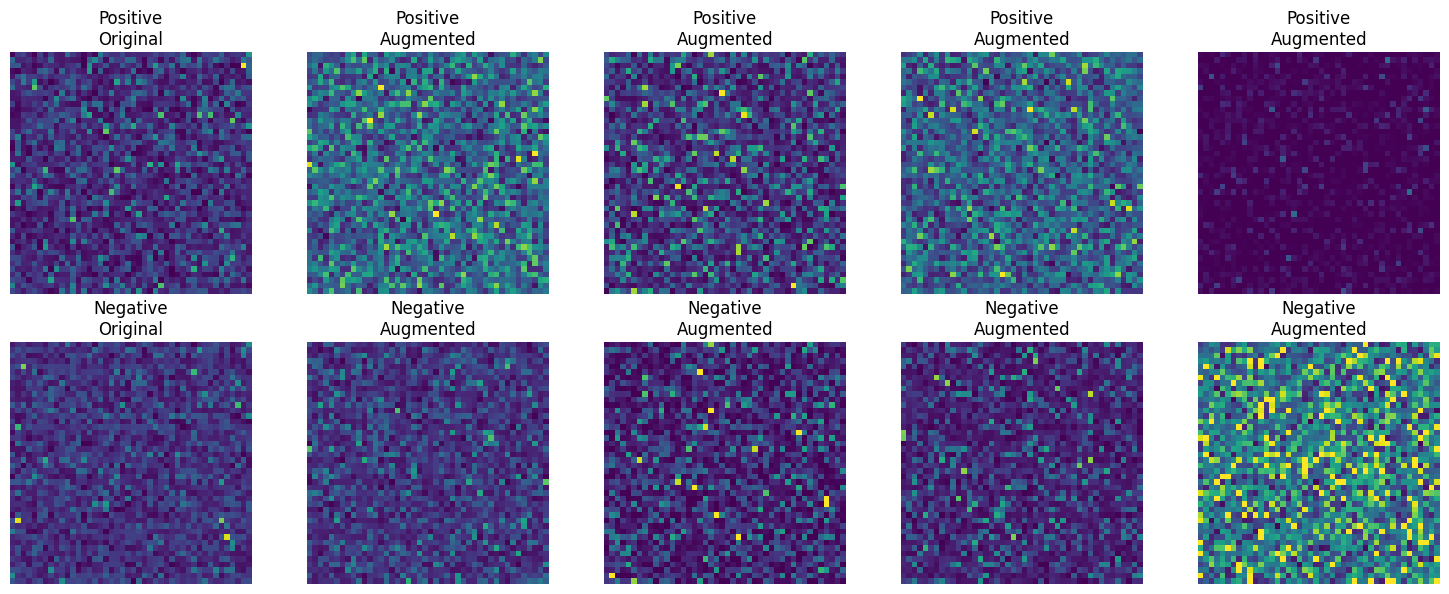

Positive class images: 500
Negative class images: 500

Original images:
Positive: 17
Negative: 32

Augmented images:
Positive: 483
Negative: 468


In [ ]:
# After augmentation is done
# After augmentation is done
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

def display_augmented_images(positive_dir, negative_dir, samples_per_class=5):
    """
    Display a grid of original and augmented images from both positive and negative classes.

    Args:
        positive_dir (str): Directory containing positive class images
        negative_dir (str): Directory containing negative class images
        samples_per_class (int): Number of images to display per class
    """
    # Create figure
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))

    # Function to get and sort image files
    def get_sorted_images(directory):
        original = [f for f in os.listdir(directory) if f.startswith('image_')]
        augmented = [f for f in os.listdir(directory) if f.startswith('aug_')]
        return original, augmented

    # Display positive class images
    orig_pos, aug_pos = get_sorted_images(positive_dir)
    for idx in range(samples_per_class):
        # Get one original and one augmented image
        if idx < len(orig_pos):
            img = Image.open(os.path.join(positive_dir, orig_pos[idx]))
            axes[0, idx].imshow(img, cmap='viridis')
            axes[0, idx].set_title(f'Positive\n{"Original" if idx == 0 else "Augmented"}')
        axes[0, idx].axis('off')

    # Display negative class images
    orig_neg, aug_neg = get_sorted_images(negative_dir)
    for idx in range(samples_per_class):
        if idx < len(orig_neg):
            img = Image.open(os.path.join(negative_dir, orig_neg[idx]))
            axes[1, idx].imshow(img, cmap='viridis')
            axes[1, idx].set_title(f'Negative\n{"Original" if idx == 0 else "Augmented"}')
        axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Print dataset statistics
    print(f"Positive class images: {len(os.listdir(positive_dir))}")
    print(f"Negative class images: {len(os.listdir(negative_dir))}")
    print("\nOriginal images:")
    print(f"Positive: {len([f for f in os.listdir(positive_dir) if f.startswith('image_')])}")
    print(f"Negative: {len([f for f in os.listdir(negative_dir) if f.startswith('image_')])}")
    print("\nAugmented images:")
    print(f"Positive: {len([f for f in os.listdir(positive_dir) if f.startswith('aug_')])}")
    print(f"Negative: {len([f for f in os.listdir(negative_dir) if f.startswith('aug_')])}")
display_augmented_images(positive_dir, negative_dir)

**DENSENET**

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.6352 - loss: 1.1370 - val_accuracy: 0.5000 - val_loss: 1.0560
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8244 - loss: 0.7657 - val_accuracy: 0.5000 - val_loss: 1.0582
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8786 - loss: 0.6743 - val_accuracy: 0.5000 - val_loss: 1.0879
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9549 - loss: 0.5067 - val_accuracy: 0.5000 - val_loss: 1.0442
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9305 - loss: 0.5440 - val_accuracy: 0.5000 - val_loss: 1.2408
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9389 - loss: 0.5198 - val_accuracy: 0.5000 - val_loss: 1.1606
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9357 - loss: 0.4927 - val_accuracy: 0.5000 - val_loss: 1.2839
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9453 - loss: 0.4665 - val_accuracy: 0.5250 - val_

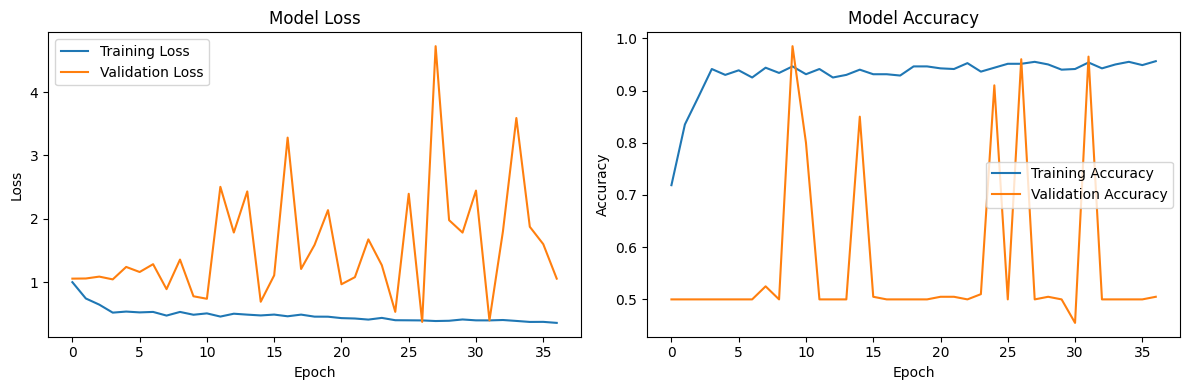

In [ ]:
from tensorflow.keras import regularizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics
import numpy as np

def build_densenet_model(input_shape, l2_strength=0.0005):
    """Build the DenseNet model with the specified input shape."""
    model = models.Sequential()

    # Convert the input to the right shape for CNN
    model.add(layers.Reshape((*input_shape, 1), input_shape=input_shape))

    # Add Conv2D layers before dense layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and continue with dense layers
    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up the generators for training and validation
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(28, 28),  # Adjust this based on your image size
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(28, 28),  # Adjust this based on your image size
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    subset='validation',
    shuffle=True
)

# Initialize the model
input_shape = (28, 28)  # Adjust based on your image size
densenet_model = build_densenet_model(input_shape)

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
densenet_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = densenet_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model
def evaluate_model(model, generator):
    # Get predictions
    y_pred = model.predict(generator)
    y_pred_binary = np.round(y_pred)

    # Get true labels
    y_true = generator.classes

    # Compute metrics
    precision = sklearn.metrics.precision_score(y_true, y_pred_binary)
    recall = sklearn.metrics.recall_score(y_true, y_pred_binary)
    f1 = sklearn.metrics.f1_score(y_true, y_pred_binary)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred_binary)

    return precision, recall, f1, accuracy

# Evaluate on training data
train_precision, train_recall, train_f1, train_accuracy = evaluate_model(
    densenet_model, train_generator
)

print('\nTraining Set Metrics:')
print(f'DenseNet Model - Precision: {train_precision:.4f}')
print(f'DenseNet Model - Recall: {train_recall:.4f}')
print(f'DenseNet Model - F1 Score: {train_f1:.4f}')
print(f'DenseNet Model - Accuracy: {train_accuracy:.4f}')

# Save the model
densenet_model.save('densenet_model.keras')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained DenseNet model
model = load_model('densenet_model.keras')

# Handle categorical variables (if needed)
label_encoder = LabelEncoder()
label_encoder.fit(['negative', 'positive'])  # Ensure the labels are mapped correctly

# Function to preprocess the uploaded image
def preprocess_image(image, target_size=(44, 44)):
    """
    Preprocesses the uploaded image:
    - Resizes to the target size.
    - Converts to grayscale (if needed).
    - Normalizes pixel values to [0, 1].
    """
    # Resize the image
    image = image.resize(target_size)

    # Convert to grayscale (if needed)
    if image.mode != 'L':
        image = image.convert('L')

    # Convert to numpy array
    image = np.array(image)

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Add batch and channel dimensions
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

# Function to make predictions
def predict(image, threshold=0.3):  # Adjust threshold
    """
    Runs inference on the preprocessed image.
    Returns predicted class (0 or 1) based on the threshold.
    """
    prediction = model.predict(image, verbose=0)
    predicted_class = int(prediction[0][0] > threshold)  # Adjust threshold
    return predicted_class, prediction[0][0]

# Upload an image
uploaded = files.upload()

# Process the uploaded image
for file_name in uploaded.keys():
    # Load the image
    image = Image.open(file_name)

    # Preprocess the image
    preprocessed_image = preprocess_image(image, target_size=(44, 44))

    # Make a prediction
    predicted_class, predicted_probability = predict(preprocessed_image, threshold=0.3)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Display the image, prediction, and raw probability
    plt.imshow(image, cmap='viridis')
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label} | Probability: {predicted_probability:.4f}')
    plt.show()

Saving download (14).png to download (14) (4).png


ValueError: Exception encountered when calling Reshape.call().

[1mCannot reshape a tensor with 1936 elements to shape [1,28,28,1] (784 elements) for '{{node sequential_7_1/reshape_3_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](sequential_7_1/Squeeze, sequential_7_1/reshape_3_1/Reshape/shape)' with input shapes: [1,44,44], [4] and with input tensors computed as partial shapes: input[1] = [1,28,28,1].[0m

Arguments received by Reshape.call():
  • inputs=tf.Tensor(shape=(1, 44, 44), dtype=float32)

**CNN**

In [ ]:
from tensorflow.keras import layers, models
import numpy as np
import sklearn.metrics

# Reshape image_data to include a single channel (grayscale)
image_data = image_data.reshape(image_data.shape[0], image_data.shape[1], image_data.shape[2], 1)

def build_cnn_model(input_shape):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Initialize and compile the model
cnn_model = build_cnn_model(image_data.shape[1:])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(image_data, y_train, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
y_pred = cnn_model.predict(image_data)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Compute evaluation metrics with matching variable names
cnn_precision = sklearn.metrics.precision_score(y_train, y_pred_binary)
cnn_recall = sklearn.metrics.recall_score(y_train, y_pred_binary)
cnn_f1 = sklearn.metrics.f1_score(y_train, y_pred_binary)
cnn_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_binary)

print(f'CNN Model - Precision: {cnn_precision:.4f}')
print(f'CNN Model - Recall: {cnn_recall:.4f}')
print(f'CNN Model - F1 Score: {cnn_f1:.4f}')
print(f'CNN Model - Accuracy: {cnn_accuracy:.4f}')

# Save the trained CNN model
cnn_model.save('cnn_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.3881 - loss: 9.8110 - val_accuracy: 0.6000 - val_loss: 38.4189
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6840 - loss: 24.7695 - val_accuracy: 0.6000 - val_loss: 6.8664
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5673 - loss: 7.1105 - val_accuracy: 0.4000 - val_loss: 10.1513
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3093 - loss: 10.4643 - val_accuracy: 0.6000 - val_loss: 4.4235
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6736 - loss: 3.2165 - val_accuracy: 0.6000 - val_loss: 5.5532
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6424 - loss: 4.1023 - val_accuracy: 0.6000 - val_loss: 2.9598
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6803 - loss: 1.8827 - val_accuracy: 0.4000 - val_loss: 1.1524
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5123 - loss: 0.8573 - val_accuracy: 0.4000 - val_loss: 

**DNN**

In [ ]:
from tensorflow.keras import layers, models
import numpy as np
import sklearn.metrics

def build_dnn_model(input_shape):
    model = models.Sequential()

    model.add(layers.Flatten(input_shape=input_shape))  # Flatten input features
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))  # Dropout to prevent overfitting

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Initialize and compile the DNN model
dnn_model = build_dnn_model(image_data.shape[1:])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the DNN model
history = dnn_model.fit(image_data, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the DNN model
y_pred = dnn_model.predict(image_data)
y_pred_binary = np.round(y_pred)  # Convert probabilities to binary predictions

# Compute evaluation metrics with matching variable names
dnn_precision = sklearn.metrics.precision_score(y_train, y_pred_binary)
dnn_recall = sklearn.metrics.recall_score(y_train, y_pred_binary)
dnn_f1 = sklearn.metrics.f1_score(y_train, y_pred_binary)
dnn_accuracy = sklearn.metrics.accuracy_score(y_train, y_pred_binary)

print(f'DNN Model - Precision: {dnn_precision:.4f}')
print(f'DNN Model - Recall: {dnn_recall:.4f}')
print(f'DNN Model - F1 Score: {dnn_f1:.4f}')
print(f'DNN Model - Accuracy: {dnn_accuracy:.4f}')

# Save the trained DNN model
dnn_model.save('dnn_model.keras')


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.5636 - loss: 22.8184 - val_accuracy: 0.6000 - val_loss: 20.1908
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6907 - loss: 21.9811 - val_accuracy: 0.4000 - val_loss: 38.5618
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3814 - loss: 46.7800 - val_accuracy: 0.6000 - val_loss: 10.3666
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6632 - loss: 15.5815 - val_accuracy: 0.6000 - val_loss: 14.9613
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7628 - loss: 12.2061 - val_accuracy: 0.6000 - val_loss: 3.4125
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4981 - loss: 25.3501 - val_accuracy: 0.6000 - val_loss: 8.9745
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6290 - loss: 21.2723 - val_accuracy: 0.7000 - val_loss: 11.8637
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6357 - loss: 19.8922 - val_accuracy: 0.6000 - val_loss: 10

**COMPARISON GRAPH BETWEEN DENSENET, CNN AND DNN**

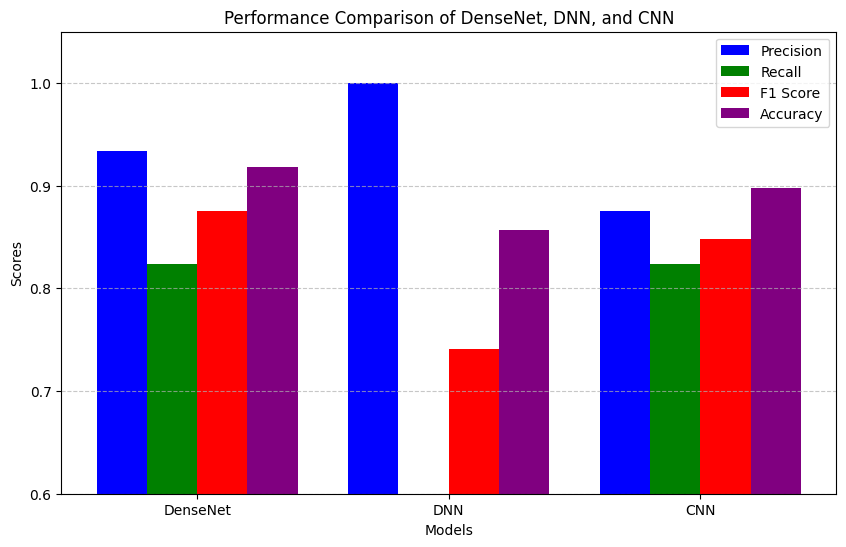

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure that metrics are extracted from lists and converted to scalars
densenet_precision = float(densenet_precision[0]) if isinstance(densenet_precision, list) else float(densenet_precision)
densenet_recall = float(densenet_recall[0]) if isinstance(densenet_recall, list) else float(densenet_recall)
densenet_f1 = float(densenet_f1[0]) if isinstance(densenet_f1, list) else float(densenet_f1)
densenet_accuracy = float(densenet_accuracy[0]) if isinstance(densenet_accuracy, list) else float(densenet_accuracy)

dnn_precision = float(dnn_precision[0]) if isinstance(dnn_precision, list) else float(dnn_precision)
dnn_recall = float(dnn_recall[0]) if isinstance(dnn_recall, list) else float(dnn_recall)
dnn_f1 = float(dnn_f1[0]) if isinstance(dnn_f1, list) else float(dnn_f1)
dnn_accuracy = float(dnn_accuracy[0]) if isinstance(dnn_accuracy, list) else float(dnn_accuracy)

cnn_precision = float(cnn_precision[0]) if isinstance(cnn_precision, list) else float(cnn_precision)
cnn_recall = float(cnn_recall[0]) if isinstance(cnn_recall, list) else float(cnn_recall)
cnn_f1 = float(cnn_f1[0]) if isinstance(cnn_f1, list) else float(cnn_f1)
cnn_accuracy = float(cnn_accuracy[0]) if isinstance(cnn_accuracy, list) else float(cnn_accuracy)

# Model names
models = ['DenseNet', 'DNN', 'CNN']

# Performance metrics
precision_values = [densenet_precision, dnn_precision, cnn_precision]
recall_values = [densenet_recall, dnn_recall, cnn_recall]
f1_score_values = [densenet_f1, dnn_f1, cnn_f1]
accuracy_values = [densenet_accuracy, dnn_accuracy, cnn_accuracy]

# Bar width
bar_width = 0.2
index = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(10, 6))

plt.bar(index, precision_values, bar_width, label='Precision', color='blue')
plt.bar(index + bar_width, recall_values, bar_width, label='Recall', color='green')
plt.bar(index + 2 * bar_width, f1_score_values, bar_width, label='F1 Score', color='red')
plt.bar(index + 3 * bar_width, accuracy_values, bar_width, label='Accuracy', color='purple')

# Labels & Title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Comparison of DenseNet, DNN, and CNN')
plt.xticks(index + 1.5 * bar_width, models)
plt.ylim(0.6, 1.05)  # Ensure all bars fit in range

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()
